In [5]:
import py4DSTEM
from py4DSTEM.io import filereaders
from py4DSTEM.visualize import show

In [6]:
dirpath = "/home/ABTLUS/victor.secco/data_processing/4D-STEM/condicao3/"

filepath_data = dirpath + "scan_x256_y256.raw"
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'

In [9]:
datacube = filereaders.empad.read_empad(filepath_data, mem='RAM', binfactor=1, metadata=False)

basics_01 = py4DSTEM.read(
    filepath_basics_01
)

basics_01.tree()

/
|---annular_dark_field
|---bright_field
|---dp_mean
|---selected_area_diffraction_01


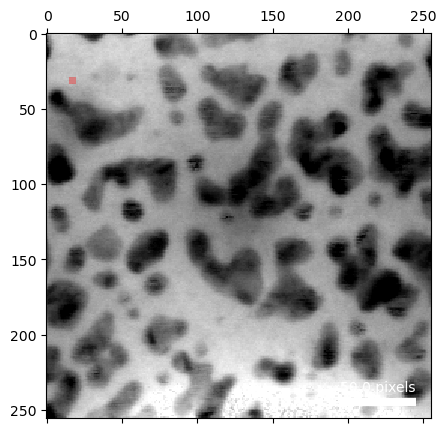

100%|██████████| 24/24 [00:00<00:00, 551.90it/s]


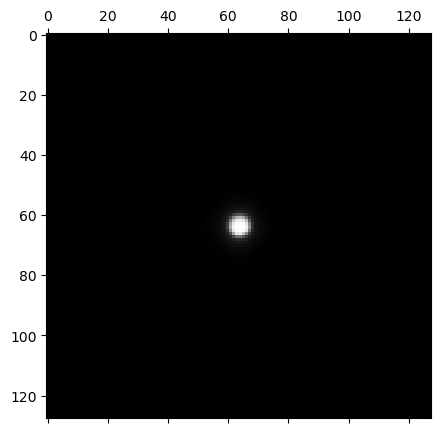

In [28]:
import numpy as np
mask = np.zeros(datacube.Rshape,dtype=bool)
mask[29:34,15:20] = 1


show(
    basics_01.tree('bright_field'),
    mask = ~mask,
    mask_alpha = 0.667,
    mask_color = 'r'
)

probe = datacube.get_vacuum_probe( ROI=mask )

show(
    probe.probe,
    scaling='none',
    intensity_range='absolute',
    vmin=0,
    vmax=3050161.5
)

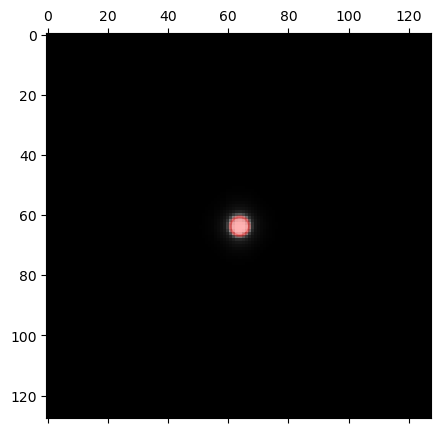

In [30]:
alpha_pr,qx0_pr,qy0_pr = datacube.get_probe_size( probe.probe )

show(
    probe.probe, 
    scaling='none',
    intensity_range='absolute',
    vmin=0,vmax=3050161.5,
    circle = {
      'center':(qx0_pr,qy0_pr),
      'R': alpha_pr,
      'alpha':0.3,
      'fill':True
    }
)

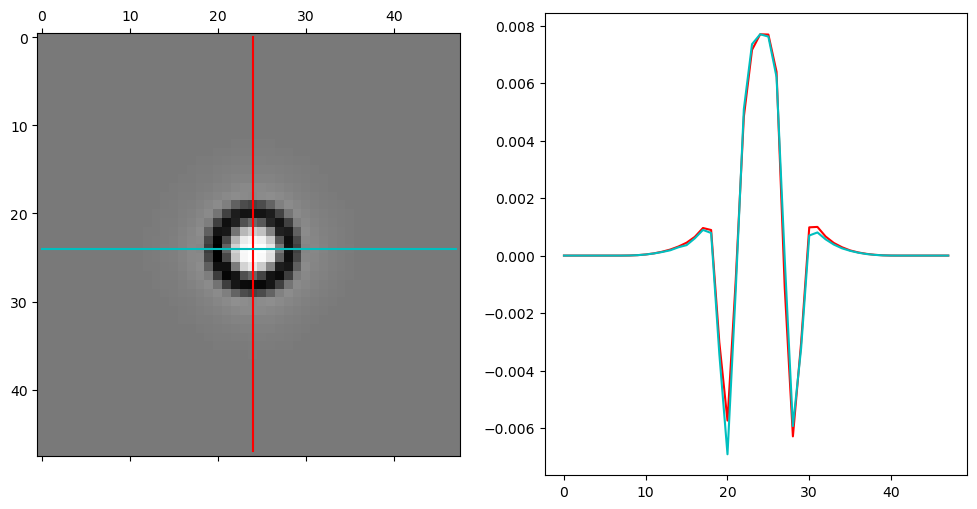

In [31]:
# prepare the probe kernel

probe.get_kernel(
    mode='sigmoid',
    origin=(qx0_pr,qy0_pr),
    radii=(alpha_pr,2*alpha_pr)   # the inner and outer radii of the 'trench'
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

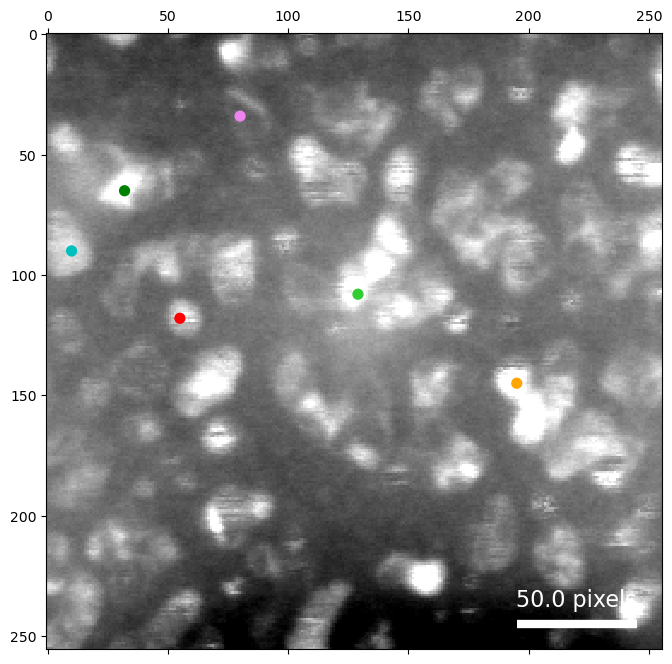

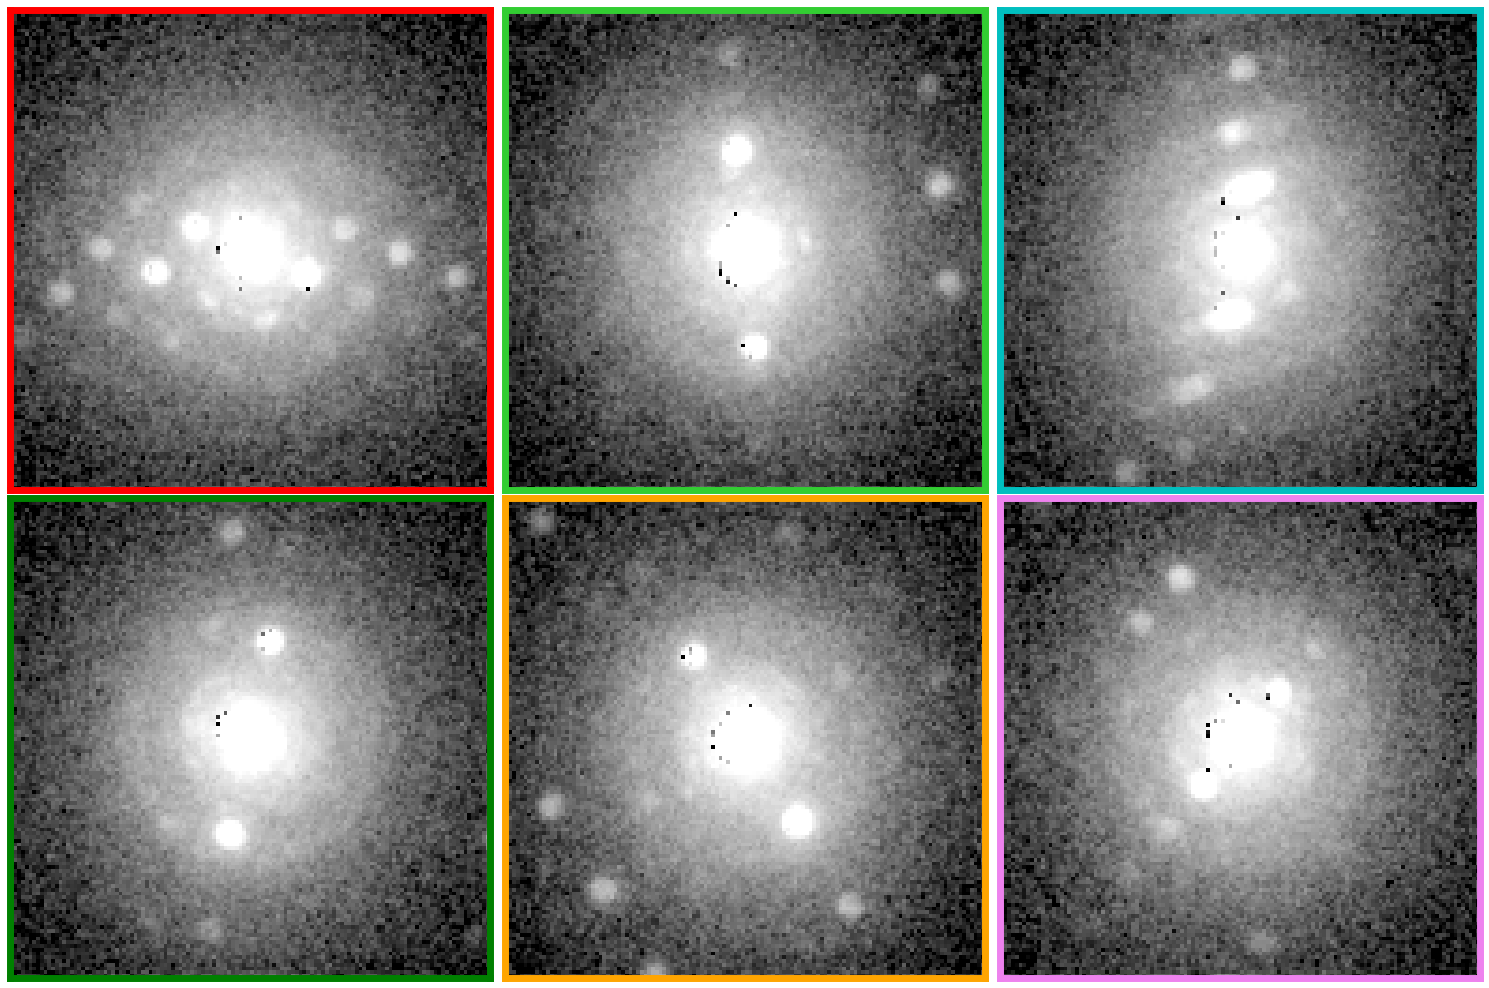

In [63]:
# Select a few sample patterns for parameter tuning


# choose scan positions

rxs = 118,108,90,65,145,34
rys = 55,129,10,32,195,80,


# visualize

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
py4DSTEM.visualize.show_points(
    basics_01.tree('annular_dark_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected
# diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    scaling='log',
    #vmin=0,
    #vmax=4.4654336,
    #scaling='power',
    #power=0.5,
    get_bordercolor = lambda i:colors[i],
)

Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1519.54
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1469.8934
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1433.539
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1517.5852
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1502.6879
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1678.0541


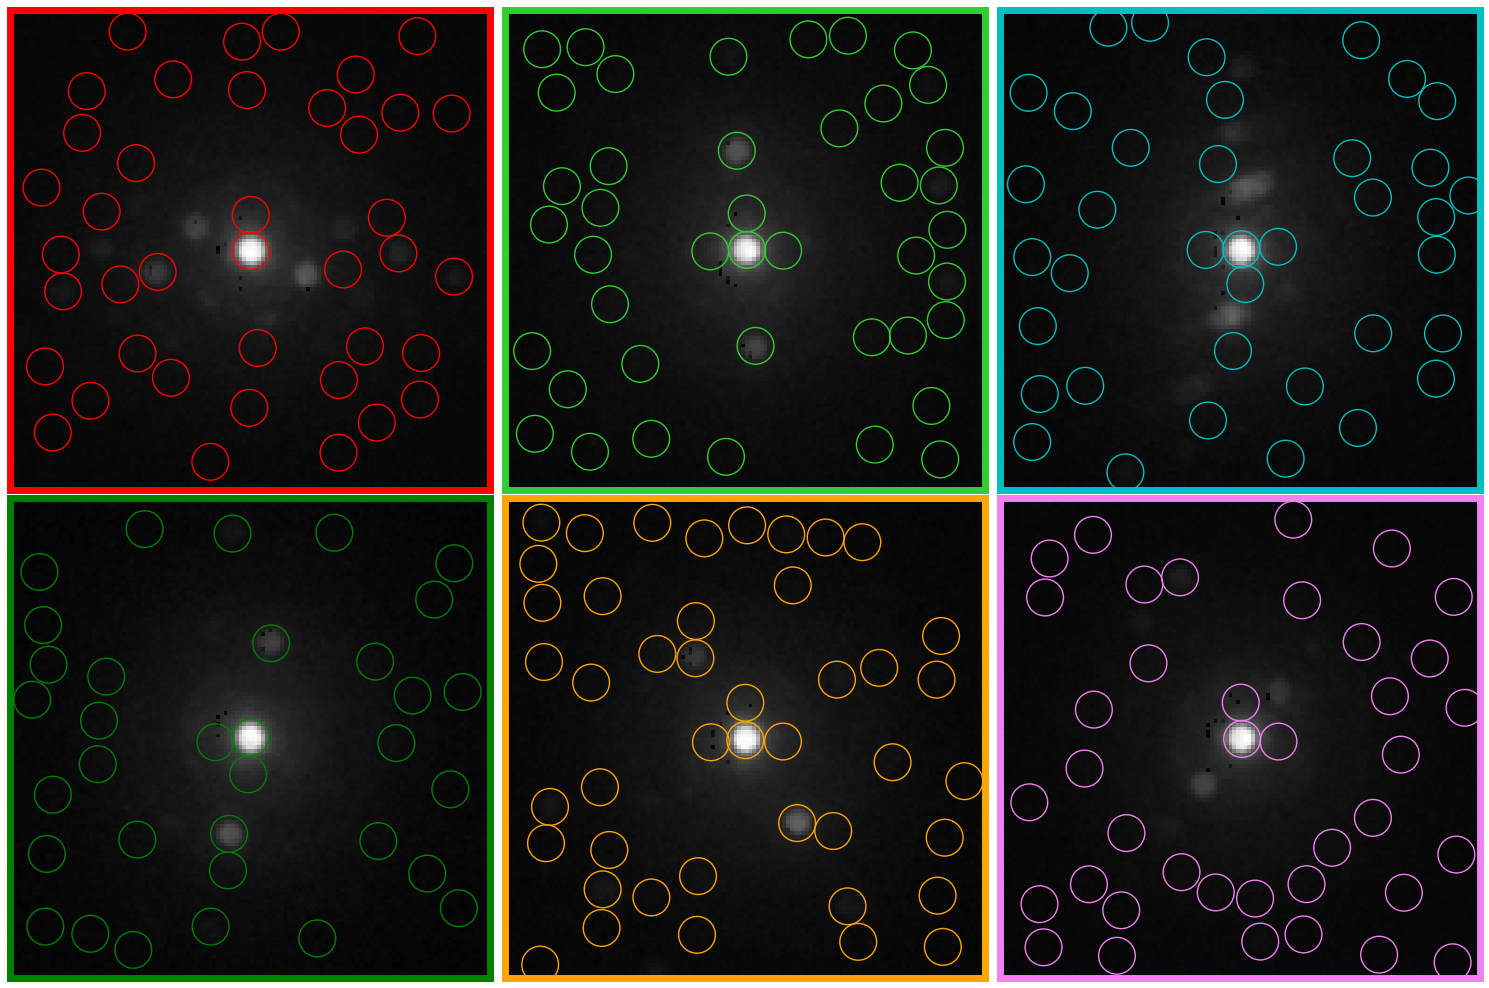

In [78]:
detect_params = {
    'minAbsoluteIntensity':20,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 10,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 2,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 3,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 100,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1.0,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}


# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    #vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)